<h2>Medical Cost Predictions</h2>
<p>Goal: predict medical costs and build a risk model for future patients</p>
<p>Sources: Meidcal Cost Dataset - Kaggle </p>

In [1]:
import pandas as pd
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
import matplotlib

/Users/mackenzieford/personal_repositories/medical_costs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
#selecting the columns that I want to be features and target predictor.  x = features, target is y
x = df.drop('charges',axis=1)
y = df['charges']

In [6]:
#Setting up processing for categorical variables 
categorical_data = ['sex','smoker','region']
numeric_data = ['age','bmi','children']
preprocessor = ColumnTransformer(transformers=[('Categories',OneHotEncoder(drop='first'),categorical_data)], remainder='passthrough')

In [7]:
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [8]:
# Train/test split data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=40)

In [9]:
#Train the pipeline
pipeline.fit(x_train,y_train)

/Users/mackenzieford/personal_repositories/medical_costs/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categories',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', LinearRegression())])

In [10]:
y_pred = pipeline.predict(x_test)
print("RMSE:",root_mean_squared_error(y_test,y_pred))
print("RScore:",r2_score(y_test,y_pred))

RMSE: 6303.795448794734
RScore: 0.7341854344194202


Just want to see what the differences are in the actual y test versus the predictions. R score is pretty good above 0.7

In [11]:

y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)
pred_actuals_df = pd.concat([y_pred_df,y_test_df],axis=1)
pred_actuals_df.columns = ['predicted_charges', 'actual_charges']
pred_actuals_df['difference'] = (pred_actuals_df['predicted_charges']- pred_actuals_df['actual_charges'])
pred_actuals_df.head()


,predicted_charges,actual_charges,difference
0,5585.495874,3227.1211,2358.374774
1,28244.629536,36307.7983,-8063.168764
2,11198.393046,7371.7720,3826.621046
3,11939.583926,8125.7845,3813.799426
4,24920.401262,14571.8908,10348.510462


In [12]:
#Trying a secondary pipeline model for Random forest
pipeline_rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=40))
])

In [13]:
model_rf = pipeline_rf
model_rf.fit(x_train,y_train)

/Users/mackenzieford/personal_repositories/medical_costs/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categories',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', RandomForestRegressor(random_state=40))])

In [14]:
y_pred_rf = model_rf.predict(x_test)
print("RMSE:",root_mean_squared_error(y_test,y_pred_rf))
print("RScore:",r2_score(y_test,y_pred_rf))

RMSE: 4861.866712920549
RScore: 0.8418822421334087


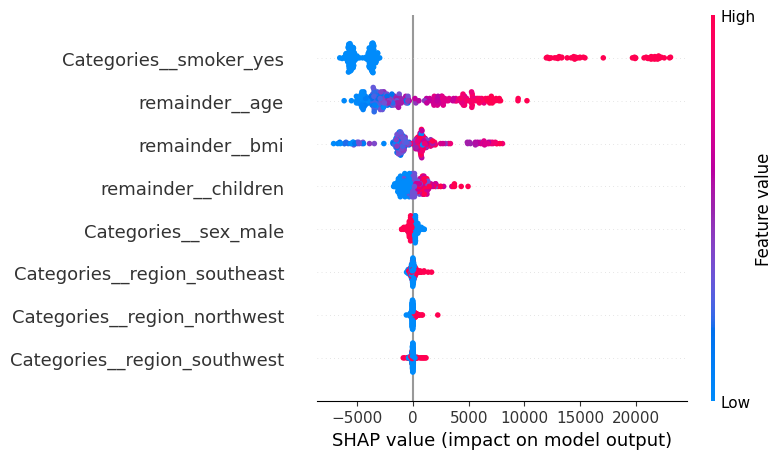

In [38]:
#Enabeling JS Visuals
shap.initjs()

#Extracting trained RF Model steps
regressor = model_rf.named_steps['regressor']
preprocessor = model_rf.named_steps['preprocess']

#get transfored features matrix for x_test
x_test_transformed = preprocessor.transform(x_test)

#get feature names after processing 
feature_names = preprocessor.get_feature_names_out()

#Converting to df for shap
x_test_transformed_df = pd.DataFrame(x_test_transformed, columns=feature_names)

#shap explainer 
explainer = shap.Explainer(regressor, x_test_transformed_df)
shap_values = explainer(x_test_transformed_df,check_additivity=False)

#plot
shap.summary_plot(shap_values,x_test_transformed_df)

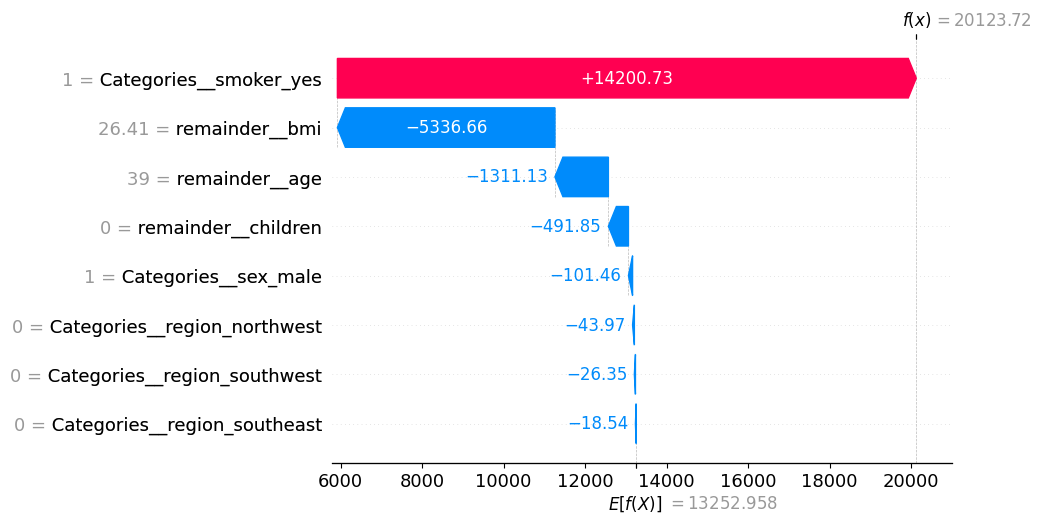

age                39
sex              male
bmi             26.41
children            0
smoker            yes
region      northeast
Name: 638, dtype: object

In [48]:
#Looking at a specific example 
i=7
shap.plots.waterfall(shap_values[i])
x_test.iloc[i]


In [52]:
print(f"actual medical cost of i: {y_test.iloc[i]}")
print(f"predicted value of i: {y_pred_df.iloc[i]}")

actual medical cost of i: 20149.3229
predicted value of i: 0    30553.994416
Name: 7, dtype: float64
